# Investigating Vision Transformer representations

**Authors:** [Aritra Roy Gosthipaty](https://twitter.com/ariG23498), [Sayak Paul](https://twitter.com/RisingSayak) (equal contribution)<br>
**Date created:** 2022/04/12<br>
**Last modified:** 2022/04/17<br>
**Description:** Looking into the representations learned by different Vision Transformers variants.

# Introduction

- 이 예제에서는 다양한 ViT로 학습이 된 representation에 대해 다룹니다.
- 주요 목표는 VIT가 이미지로 부터 무엇을 학습하는지 분석하고 이해하는 것. 

Note : 여기서 말하는 Vision Transformer는 우리가 일반적으로 알고 있는 ViT 아키텍처 뿐만 아니라 원래의 트랜스포머 구조를 사용하는 Vision 아키텍처 모두를 포함함

# Model Considered

- 오리지널 비전 트랜스포머(ViT)의 이후, 학습 개선, 구조 개선 등 다양한 방식으로 오리지널을 개선하는 다양한 ViT 변형을 보여옴. 이 예에서는 다음 ViT 모델들을 고려합니다.
    - 데이터셋 이미지넷-1k | 이미지넷-21k로 지도방식으로 사전학습 된 ViT
    - 지도방식으로 사전학습되었지만 이미지넷-1k만을 사용했고 더 많은 규제와 distillation을 사용 (DeiT)
    - 오직 self-supervised pretraining 된 ViT (DINO)



## 모듈 

In [ ]:
import zipfile
from io import BytesIO

import cv2
import gdown
import matplotlib.pyplot as plt
import numpy as np
import requests
import tensorflow as tf
import tensorflow_hub as hub
from PIL import Image
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras

## 하이퍼 파라미터 

In [ ]:
#ViT 에서는 이미지를 패치 단위로 나누기 때문에 PATCH_SIZE 하이퍼 파라미터를 설정 함 
#RESOLUTION은 이미지 사이즈를 의미 함 
RESOLUTION = 224
PATCH_SIZE = 16

## 데이터 전처리 함수 
- 오리지널 ViT에 맞추기 위해 이미지들의 픽셀 값들을 [-1,1]의 범위로 스케일링 할 필요가 있음 
- 앞서 언급된 다른 ViT에 대해서는 channel-wise 로 이미지넷-1k 데이터의 mean 값과 표준편차 값을 이용해 normalized 해주어야 함 



In [ ]:
#이미지를 RESOULTION에 맞춰서 CROP함 
crop_layer = keras.layers.CenterCrop(RESOLUTION, RESOLUTION)
#해당 mean, std 값에 맞춰 Normalization 진행 
norm_layer = keras.layers.Normalization(
    mean=[0.485 * 255, 0.456 * 255, 0.406 * 255],
    variance=[(0.229 * 255) ** 2, (0.224 * 255) ** 2, (0.225 * 255) ** 2],)  
# for others ViT 
rescale_layer = keras.layers.Rescaling(scale=1.0 / 127.5, offset=-1) #for Original ViT 


def preprocess_image(image, model_type, size=RESOLUTION):
    image = np.array(image)
    image = tf.expand_dims(image, 0)

    # 만약 모델 타입이 오리지널 ViT인 경우 [-1,1] 범위로 이미지를 rescaling 
    if model_type == "original_vit":
        image = rescale_layer(image)


    # bicubic interpolation를 이용해 이미지 Resize 
    # bicubic interpolation : 이미지 사이즈를 바꾸기 위해 사용되는 보간법으로 인접한 16개 화소의 값과 거리에 따른 가중치의 곱을 사용하여 결정 
    resize_size = int((256 / 224) * size)
    image = tf.image.resize(image, (resize_size, resize_size), method="bicubic")

    # 이미지 크롭 
    image = crop_layer(image)

    #만약 모델 타입이 오리지널 ViT가 아닌 DeiT 또는 DINO인 경우 이미지 Normalize 진행 
    if model_type != "original_vit":
        image = norm_layer(image)

    return image.numpy()

# URL로 부터 이미지 로드 
# 이미지를 로드한 뒤 바로 전처리 진행 
def load_image_from_url(url, model_type):
    # Credit: Willi Gierke
    response = requests.get(url)
    image = Image.open(BytesIO(response.content))
    preprocessed_image = preprocess_image(image, model_type)
    return image, preprocessed_image


## 테스트 이미지 로드 및 display 

21675/21675 [==============================] - 0s 0us/step


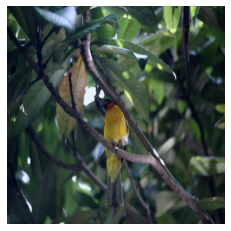

In [ ]:
# ImageNet-1k label mapping file and load it.
# 이미지넷-1k 이미지,라벨 다운 
mapping_file = keras.utils.get_file(
    origin="https://storage.googleapis.com/bit_models/ilsvrc2012_wordnet_lemmas.txt"
)

with open(mapping_file, "r") as f:
    lines = f.readlines()
imagenet_int_to_str = [line.rstrip() for line in lines]

img_url = "https://dl.fbaipublicfiles.com/dino/img.png"
image, preprocessed_image = load_image_from_url(img_url, model_type="original_vit")

plt.imshow(image)
plt.axis("off")
plt.show()

## 모델 로드 
- 학습된 모델 로드 
   

In [ ]:
def get_tfhub_model(model_url: str) -> tf.keras.Model:
    inputs = keras.Input((RESOLUTION, RESOLUTION, 3))
    hub_module = hub.KerasLayer(model_url)
    outputs, attention_weights = hub_module(inputs)
    return keras.Model(inputs, outputs=[outputs, attention_weights])


def get_gdrive_model(model_id: str) -> tf.keras.Model:
    model_path = gdown.download(id=model_id, quiet=False)
    with zipfile.ZipFile(model_path, "r") as zip_ref:
        zip_ref.extractall()
    model_name = model_path.split(".")[0]
    inputs = keras.Input((RESOLUTION, RESOLUTION, 3))
    model = keras.models.load_model(model_name, compile=False)
    outputs, attention_weights = model(inputs)
    return keras.Model(inputs, outputs=[outputs, attention_weights])


def get_model(url_or_id):
    if "https" in url_or_id:
        loaded_model = get_tfhub_model(url_or_id)
    else:
        loaded_model = get_gdrive_model(url_or_id)
    return loaded_model

# 미리 학습되어 있는 Pretrained model 로드 
# 오리지널 ViT, 학습데이터 : 이미지넷-21k, path_size : 16, image_size : 224 
vit_base_i21k_patch16_224 = get_model("1mbtnliT3jRb3yJUHhbItWw8unfYZw8KJ")
print("Model loaded.")

Downloading...
From: https://drive.google.com/uc?id=1mbtnliT3jRb3yJUHhbItWw8unfYZw8KJ
To: /content/vit_b16_patch16_224.zip
100%|██████████| 322M/322M [00:01<00:00, 209MB/s]


Model loaded.


In [ ]:
vit_base_i21k_patch16_224.summary()

NameError: ignored

**모델 정보**
 - 사전 학습 데이터 : ImageNet-21k 
 - 파인 튜닝 데이터 : ImageNet-1k
 - 트랜스포머 블록 수 : 12 
 - Head 수 : 12 
 - 패치 수 : 16 
 - 이미지 사이즈 : 224 
- 모델 학습 정보나 weights 정보는 [노트북](https://github.com/sayakpaul/probing-vits/blob/main/notebooks/load-jax-weights-vitb16.ipynb) or [소스](https://github.com/google-research/vision_transformer/) 참고 


## 일반적인 모델 Inference 시행 
- 앞서 로드한 테스트 이미지에 로드된 모델로 라벨 예측 추론 진행 


In [ ]:
predictions, attention_score_dict = vit_base_i21k_patch16_224.predict(
    preprocessed_image
)
predicted_label = imagenet_int_to_str[int(np.argmax(predictions))]
print(f'해당 이미지의 라벨 : {predicted_label}')

1/1 [==============================] - 2s 2s/step
해당 이미지의 라벨 : bulbul


`attention_score_dict` 는 각 트랜스포머 블록의 어텐션 레이러로 부터 얻은 어텐션 스코어를 담고 있음 

# Application of Representation from ViT
- 앞선 과정에서 학습된 ViT를 로드하였고, 이미지를 통해 정상적으로 추론이 됨을 확인 함 
- 이제 진행할 것들은 학습 된 ViT로 부터 이미지의 Representation을 추출하고 활용할 수 있는 방법들을 소개할 예정

## Method I: Mean attention distance 
- [Dosovitskiy et al.](https://arxiv.org/abs/2010.11929) and
[Raghu et al.](https://arxiv.org/abs/2108.08810) 에서 에서 로컬, 글로벌 정보가 어떻게 ViT로 흐르는지를 이해하기 위해 각기 다른 트랜스포머 블록의 헤드에서 나오는 mean attention distance를 사용 
- Mean attention distance는 distance matrix * attention weights로 정의 되며 distance matrix는 query token과 나머지 token 간의 거리 matrix  

단일 이미지에 대해   
  - 이미지를 Patches(tokens) 분할 
  - 패치들 간의 기하학적 거리(geometric distance) 계산 
  - 이 distance 들과 attention score를 곱 

어텐션 스코어는 이미지를 inference한 뒤에 계산이 되며 아래 영상은 이해를 돕기 위한 예시 영상 

<img src="https://i.imgur.com/pZCgPwl.gif" height=500>

This animation is created by [Ritwik Raha](https://twitter.com/ritwik_raha).

In [ ]:
#패치들(토큰들) 간 distance 계산 
def compute_distance_matrix(patch_size, num_patches, length):
    distance_matrix = np.zeros((num_patches, num_patches))
    for i in range(num_patches):
        for j in range(num_patches):
            if i == j:  # zero distance
                continue

            xi, yi = (int(i / length)), (i % length)
            xj, yj = (int(j / length)), (j % length)
            distance_matrix[i, j] = patch_size * np.linalg.norm([xi - xj, yi - yj])

    return distance_matrix


def compute_mean_attention_dist(patch_size, attention_weights, model_type):
    #CLS 토큰 수 
    num_cls_tokens = 2 if "distilled" in model_type else 1

    # The attention_weights shape = (batch, num_heads, num_patches, num_patches)
    # CLS 토큰 제거 : 제일 앞에 있는 것이 CLS 토큰 
    attention_weights = attention_weights[
        ..., num_cls_tokens:, num_cls_tokens:
    ]  
    num_patches = attention_weights.shape[-1]
    length = int(np.sqrt(num_patches))
    assert length**2 == num_patches, "Num patches is not perfect square" 

    #각 패치들 간의 distance 계산 -> matrix 생성 
    distance_matrix = compute_distance_matrix(patch_size, num_patches, length) #(196,196), patch_size = 16 
    h, w = distance_matrix.shape
    distance_matrix = distance_matrix.reshape((1, 1, h, w))

    '''
    attention_weights * distance_matrix의 sum, mean을 통해 patches(toekn)들 간의 mean attention distance 계산 

    # The attention_weights along the last axis adds to 1
    # this is due to the fact that they are softmax of the raw logits
    # summation of the (attention_weights * distance_matrix)
    # should result in an average distance per token.
    '''
    mean_distances = attention_weights * distance_matrix
    mean_distances = np.sum(
        mean_distances, axis=-1
    )  #토큰 별 평균 distance를 얻기 위해 마지막 축에 따라 summation 
    mean_distances = np.mean(
        mean_distances, axis=-1
    ) # 이제 모든 토큰에 대해 평균 계산 
    return mean_distances


Thanks to [Simon Kornblith](https://scholar.google.com/citations?user=1O3RPmsAAAAJ&hl=en)
from Google who helped us with this code snippet. It can be found
[here](https://gist.github.com/simonster/155894d48aef2bd36bd2dd8267e62391). Let's now use
these utilities to generate a plot of attention distances with our loaded model and test
image.

Num Heads: 12.


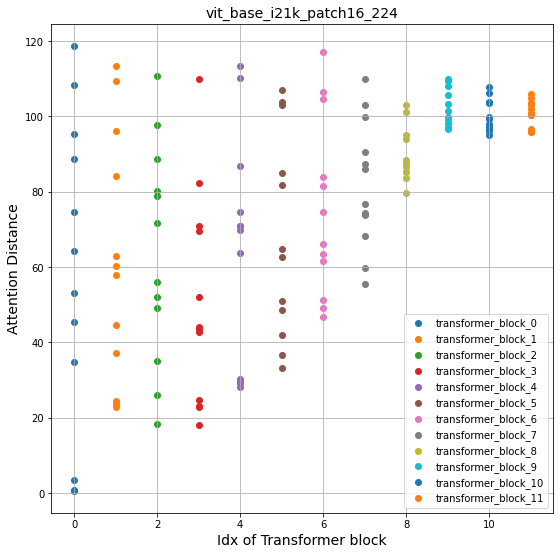

In [ ]:
# 모든 트랜스포머 블록에 대해 mean distance 들 계산 
mean_distances = {
    f"{name}_mean_dist": compute_mean_attention_dist(
        patch_size=PATCH_SIZE,
        attention_weights=attention_weight,
        model_type="original_vit",
    )
    for name, attention_weight in attention_score_dict.items()
}
# mean distance output으로 부터 헤드의 수를 얻음 
# 이 예제에서 헤드의 수는 12개 
num_heads = tf.shape(mean_distances["transformer_block_0_att_mean_dist"])[-1].numpy()
print(f"Num Heads: {num_heads}.")

plt.figure(figsize=(9, 9))

for idx in range(len(mean_distances)):
  mean_distance = mean_distances[f"transformer_block_{idx}_att_mean_dist"]
  x = [idx] * num_heads
  y = mean_distance[0, :]
  plt.scatter(x=x, y=y, label=f"transformer_block_{idx}")
  #x = np.arange(num_heads)
  #plt.plot(x, y,'-o', label=f"transformer_block_{idx}",marker=maker)

plt.legend(loc="lower right")
plt.xlabel("Idx of Transformer block", fontsize=14)
plt.ylabel("Attention Distance", fontsize=14)
plt.title("vit_base_i21k_patch16_224", fontsize=14)
plt.grid()
plt.show()

### Inspecting the plots

**self-attention은 어떻게 input space에 걸쳐 퍼져 나가나? 그들은 input regions을 locally하게 보는가 혹은 globally하게 보는가?** 

- self-attention은 모델이 가장 두드러진 목표에 대해 입력 영역에 집중할 수 있도록 문맥적 의존성을 학습할 수 있도록 하는 것이다.

- 위 그림으로 부터 우리는 다른 attention heads에 따라 각기 다른 attnention distances를 형성하는 것을 알 수 있으며, 이는 트래스포머가 이미지로 부터 local, global 정보를 모두 사용한다는 것을 의미한다. 하지만 더 깊은 트랜스포머 블록으로 갈 수록 attention heads는 더 종합적인 global information에 집중하는 경향이 있다.

- [Raghu et al.](https://arxiv.org/abs/2108.08810)로 부터 영감을 받아, Imagenet-1k에서 랜덤하게 추출 된 1000개의 이미지로 부터 mean attention distances를 계산 했다. 그리고 앞선 과정을 동일하게 반복했으며 흥미로운 사실을 발견할 수 있었다.

**더 큰 데이터 셋으로 사전학습할 경우 더 global attention을 갖는 경향이 있음:**


| Pretrained on ImageNet-21k<br>Fine-tuned on ImageNet-1k | Pretrained on ImageNet-1k |
| :--: | :--: |
| ![](https://drive.google.com/uc?export=view&id=1aFob5Cj0FkRyVhH4Iw7Dh5SFxQH3rpYs) | ![](https://drive.google.com/uc?export=view&id=13Y-3Ypi58PPRqd-pqP1oHkyNkRHCYypH) |


**CNN으로 부터 distilled 되는 경우, ViT는 덜 global attention을 갖는 경향이 있다 :** 


| No distillation (ViT B-16 from DeiT) | Distilled ViT B-16 from DeiT |
| :--: | :--: |
| ![](https://drive.google.com/uc?export=view&id=1yH4cPQcMFCnuo3-IW3S9Baszr_d0o2Se) | ![](https://drive.google.com/uc?export=view&id=1m_nG12kq7E_zIEkxhsi7U0Xr_VDXhJYE) |

To reproduce these plots, please refer to
[this notebook](https://github.com/sayakpaul/probing-vits/blob/main/notebooks/mean-attention-distance-1k.ipynb).

## Method 2: Attention Rollout 
 
- [Abnar et al.](https://arxiv.org/abs/2005.00928) 에서는 "Attention rollout"을 소개 함 
- "Attention rollout"이란 트랜스포머 블록의 self-attention layer를 통해 이미지의 정보가 어떻게 흐르는지 정량화를 하기 위한 방법 
- Original ViT의 저자는 이 방법을 이용해 학습된 representation을 분석하는 데 사용 

>정리하자면 ViTL/16의 모든 헤드에 대해 attention weights를 평균을 낸 다음 모든 레이어의 weight matrices와 곱함. 이는 모든 레이어를 통해 토큰 간에 attention이 mixing됨을 설명 함 

Attention Rollout을 보여주기 위해 이 [노트북](https://colab.research.google.com/github/jeonsworld/ViT-pytorch/blob/main/visualize_attention_map.ipynb)을 참고하였으며 모델과의 호환성을 위해 수정 함 

In [ ]:
def attention_rollout_map(image, attention_score_dict, model_type):
    num_cls_tokens = 2 if "distilled" in model_type else 1

    # Stack the individual attention matrices from individual Transformer blocks.
    # 각 트랜스포머 블록에서 attention matrices stack 
    attn_mat = tf.stack([attention_score_dict[k] for k in attention_score_dict.keys()])
    attn_mat = tf.squeeze(attn_mat, axis=1)

    # Average the attention weights across all heads.
    # 모든 헤드에 대해 attention weights 평균 
    # 12개 헤드 -> 1개 : 평균 
    attn_mat = tf.reduce_mean(attn_mat, axis=1)


    '''
    residual connection을 처리하기 위해 attention matrix에 
    identity matrix를 추가하며 weight의 re-normalize 진행 
    '''
    residual_attn = tf.eye(attn_mat.shape[1])
    aug_attn_mat = attn_mat + residual_attn
    aug_attn_mat = aug_attn_mat / tf.reduce_sum(aug_attn_mat, axis=-1)[..., None]
    aug_attn_mat = aug_attn_mat.numpy()

    # Recursively multiply the weight matrices.
    joint_attentions = np.zeros(aug_attn_mat.shape)
    joint_attentions[0] = aug_attn_mat[0]

    for n in range(1, aug_attn_mat.shape[0]):
        joint_attentions[n] = np.matmul(aug_attn_mat[n], joint_attentions[n - 1])

    # Attention from the output token to the input space.
    v = joint_attentions[-1]
    grid_size = int(np.sqrt(aug_attn_mat.shape[-1]))
    mask = v[0, num_cls_tokens:].reshape(grid_size, grid_size)
    mask = cv2.resize(mask / mask.max(), image.size)[..., np.newaxis]
    result = (mask * image).astype("uint8")
    return result  

Let's now use these utilities to generate an attention plot based on our previous results
from the "Running regular inference with the model" section. Following are the links to
download each individual model:

* [Original ViT model (pretrained on ImageNet-21k)](https://drive.google.com/file/d/1mbtnliT3jRb3yJUHhbItWw8unfYZw8KJ/view?usp=sharing)
* [Original ViT model (pretrained on ImageNet-1k)](https://drive.google.com/file/d/1ApOdYe4NXxhPhJABefgZ3KVvqsQzhCL7/view?usp=sharing)
* [DINO model (pretrained on ImageNet-1k)](https://drive.google.com/file/d/16_1oDm0PeCGJ_KGBG5UKVN7TsAtiRNrN/view?usp=sharing)
* [DeiT models (pretrained on ImageNet-1k including distilled and non-distilled ones)](https://tfhub.dev/sayakpaul/collections/deit/1)

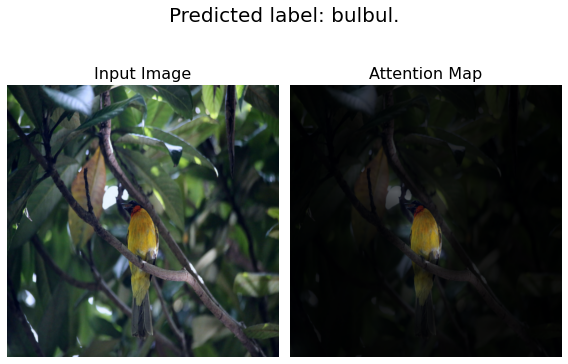

In [ ]:
attn_rollout_result = attention_rollout_map(
    image, attention_score_dict, model_type="original_vit"
)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 10))
fig.suptitle(f"Predicted label: {predicted_label}.", fontsize=20)

_ = ax1.imshow(image)
_ = ax2.imshow(attn_rollout_result)
ax1.set_title("Input Image", fontsize=16)
ax2.set_title("Attention Map", fontsize=16)
ax1.axis("off")
ax2.axis("off")

fig.tight_layout()
fig.subplots_adjust(top=1.35)
fig.show()

### Inspecting the plots

**어떻게 attention layer를 통해 전파되는 이미지의 정보 흐름을 정량화 할 수 있을까?** 
- 입력 이미지에서 모델이 집중하는 부분을 확인할 수 있음 
- Attention rollout 그림은 모델이 학습 한 task와 augmentation에 따라 달라질 수 있음 
- DeiT의 representation으로 rollout했을 때 가장 좋은 그림을 보였으며, 이는 DeiT 모델의 Augmentation 조합 때문 


## Method 3: Attention heatmaps 
- Vision Transformer의 representation을 분석하는 간단하면서 유용한 방법은 입력 이미지에 겹쳐진 attention map을  시각화 하는 것 
- 이는 모델이 무엇에 집중을 하는 것에 대한 직관을 형성하는데 도움을 줌 

- 이번엔 ViT 모델로 DINO를 사용하며, 더 나은 attention heatmap을 보여주기 떄문 

- 트랜스포머 블록은 multiple heads로 구성되어 있음 
- 트랜스포머 블록의 각 head는 input data를 다른 sub-space로 투영하며 이는 각 헤드들이 이미지의 서로 다른 파트에 집중하는 데 도움을 줌 
- 따라서 각 attention haedmap을 개별적으로 시각화 하여 각 헤드가 무엇을 보고 있는지 파악할 수 있음 

**Notes:**
- 아래 코드는 [original DINO codebase](https://github.com/facebookresearch/dino/blob/main/visualize_attention.py).를 참고하여 만듦
- 마지막 트랜스포머 블록의 attention map을 사용 함 
- [DINO](https://arxiv.org/abs/2104.14294)는 self-supervised 로 사전학습이 됨 

In [ ]:
# Load the model.
vit_dino_base16 = get_model("16_1oDm0PeCGJ_KGBG5UKVN7TsAtiRNrN")
print("Model loaded.")

# Preprocess the same image but with normlization.
img_url = "https://dl.fbaipublicfiles.com/dino/img.png"
image, preprocessed_image = load_image_from_url(img_url, model_type="dino")

# Grab the predictions.
predictions, attention_score_dict = vit_dino_base16.predict(preprocessed_image)

Downloading...
From: https://drive.google.com/uc?id=16_1oDm0PeCGJ_KGBG5UKVN7TsAtiRNrN
To: /content/vit_dino_base16.zip
100%|██████████| 326M/326M [00:05<00:00, 56.8MB/s]


Model loaded.
1/1 [==============================] - 2s 2s/step


In [ ]:
def attention_heatmap(attention_score_dict, image, model_type="dino"):
    num_tokens = 2 if "distilled" in model_type else 1

    # Depth에 맞게 트랜스포머 블록 정렬 
    attention_score_list = list(attention_score_dict.keys())
    attention_score_list.sort(key=lambda x: int(x.split("_")[-2]), reverse=True)

    # Process the attention maps for overlay.  
    w_featmap = image.shape[2] // PATCH_SIZE
    h_featmap = image.shape[1] // PATCH_SIZE
    attention_scores = attention_score_dict[attention_score_list[0]] #제일 마지막 Transformer block 선택 : Transformer_block_11

    # CLS 토큰 제외 
    attentions = attention_scores[0, :, 0, num_tokens:].reshape(num_heads, -1)

    # Reshape the attention scores to resemble mini patches. 
    attentions = attentions.reshape(num_heads, w_featmap, h_featmap)
    attentions = attentions.transpose((1, 2, 0))

    # Resize the attention patches to 224x224 (224: 14x16).
    attentions = tf.image.resize(
        attentions, size=(h_featmap * PATCH_SIZE, w_featmap * PATCH_SIZE)
    )
    return attentions


DINO 모델의 Inference에서 사용된 동일한 이미지와 `attention_score_dict`를 사용 함 

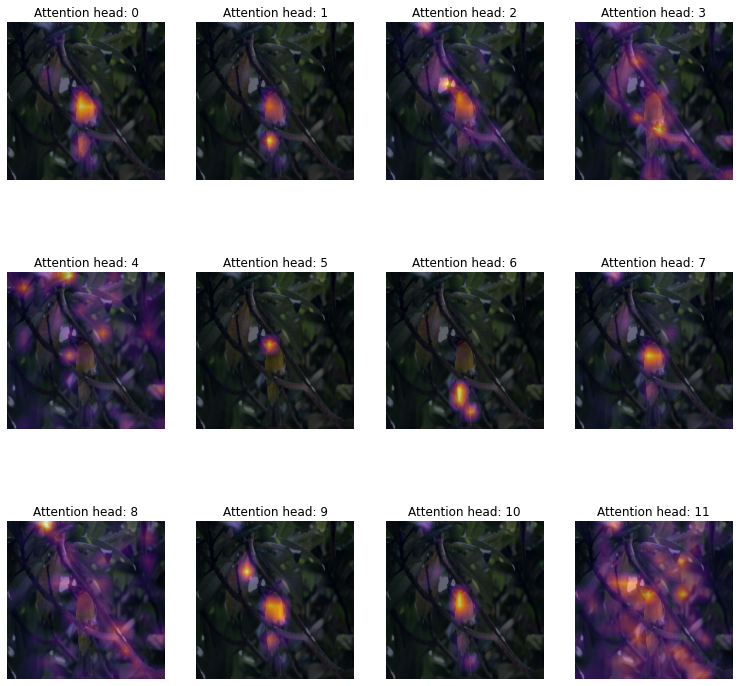

In [ ]:
# De-normalize the image for visual clarity.
# 선명한 시각화를 위해 이미지 De-normalize 
in1k_mean = tf.constant([0.485 * 255, 0.456 * 255, 0.406 * 255])
in1k_std = tf.constant([0.229 * 255, 0.224 * 255, 0.225 * 255])
preprocessed_img_orig = (preprocessed_image * in1k_std) + in1k_mean
preprocessed_img_orig = preprocessed_img_orig / 255.0
preprocessed_img_orig = tf.clip_by_value(preprocessed_img_orig, 0.0, 1.0).numpy()

# Generate the attention heatmaps.
attentions = attention_heatmap(attention_score_dict, preprocessed_img_orig)

# Plot the maps.
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(13, 13))
img_count = 0

for i in range(3):
    for j in range(4):
        if img_count < len(attentions):
            axes[i, j].imshow(preprocessed_img_orig[0]) #원본 이미지 
            axes[i, j].imshow(attentions[..., img_count], cmap="inferno", alpha=0.6) #attention heatmap 
            axes[i, j].title.set_text(f"Attention head: {img_count}")
            axes[i, j].axis("off")
            img_count += 1

### Inspecting the plots 
**attention weights를 어떻게 정량적으로 평가할 수 있을까?** 
- 트랜스포머 블록의 attention weights는 key와 query에 의해 계산이 되며, weights는 key가 query에 대해 얼마나 중요한 가를 측정한다. 
- ViT에서는 key와 query가 같은 이미지에서 추출되며, 따라서 weights는 이미지의 어떤 part가 중요한가를 의미한다. 

- 이미지에 attentionw weights를 겹친 시각화는 트랜스포머에게 중요하게 여겨지는 이미지 파트에 대한 직관을 우리에게 제공한다. 
- 이 그림은 정량적으로 attention weights의 목적을 평가한다. 

## Method IV: Visualizing the learned projection filters

- non-overlapping patches를 추출한 뒤 ViT는 패치들의 saptial dimensions에 따라 flatten 하며, 그 뒤 선형적으로 투영한다. 
- 한가지 궁금증이 생기게 되는데 이 투영된 것들은 어떻게 생겼는가?
- 아래에서 ViTB-16 모델을 사용하며 학습된 투영을 시각화 한다. 


In [ ]:
scaled_projections.shape

(16, 16, 3, 768)

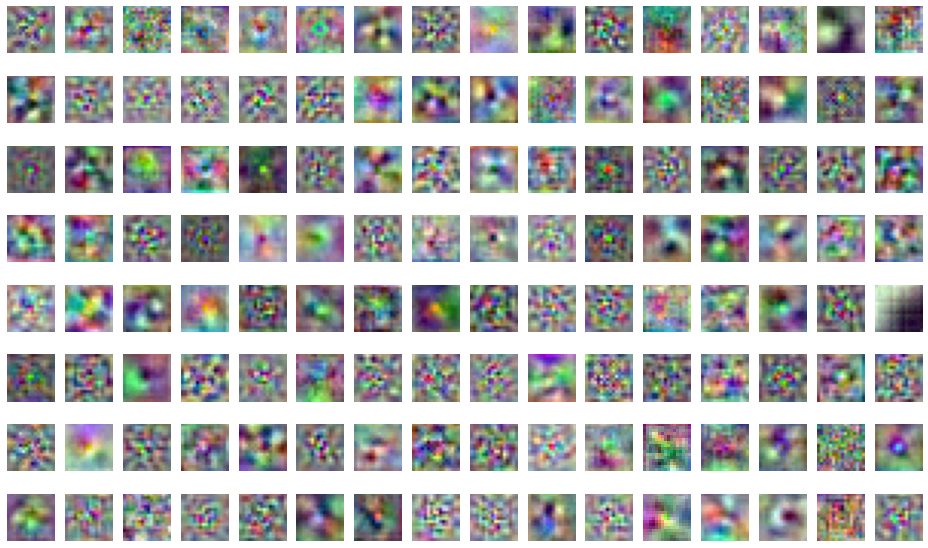

In [ ]:
# Projection layer 추출 
projections = (
    vit_base_i21k_patch16_224.layers[1]
    .get_layer("projection")
    .get_layer("conv_projection")
    .kernel.numpy()
)
projection_dim = projections.shape[-1]
patch_h, patch_w, patch_channels = projections.shape[:-1]

# Scale the projections.
scaled_projections = MinMaxScaler().fit_transform(
    projections.reshape(-1, projection_dim)
)

# Reshape the scaled projections so that the leading
# three dimensions resemble an image.
scaled_projections = scaled_projections.reshape(patch_h, patch_w, patch_channels, -1)


# 첫 128개의 학습된 필터를 시각화 
# projections.
fig, axes = plt.subplots(nrows=8, ncols=16, figsize=(13, 8))
img_count = 0
limit = 128

for i in range(8):
    for j in range(16):
        if img_count < limit:
            axes[i, j].imshow(scaled_projections[..., img_count])
            axes[i, j].axis("off")
            img_count += 1

fig.tight_layout()

### Inspecting the plots

**프로젝션 필터는 무엇을 학습하는가?**
- [시각화](https://distill.pub/2017/feature-visualization/)를 했을 때 convolution neural network의 커널은 이미지에서 찾고자 하는 패턴을 보여준다. 
- 이것은 원일 수도 있고 때로는 선일 수도 있으며, 함께 결합될 때 (ConvNet의 후기 단계에서) 필터는 더 복잡한 모양으로 변환된다. 그러한 ConvNet 커널과 ViT의 투영 필터 사이의 극명한 유사성을 발견함 

## Method V: Visualizing the positional emebddings

- 트랜스포머는 permutation-invariant 함 
- 이는 입력 토큰의 공간 위치를 고려하지 않음을 의미하며, 즉 이미지를 패치로 분할한 뒤 위치 정보가 사라지며 이러한 한계를 극복하기 위해 입력 토큰에 위치 정보를 추가한다. 
- 위치정보는 학습된 위치 임베딩 또는 수작업으로 만든 상수 임베딩 형태를 사용할 수 있다. 
- 이 경우 ViT의 세가지 변형(original, DINO,DeiT) 모두 학습된 위치 임베딩을 사용함 

- 이번 파트에서는 학습된 Positional Embeddings 간의 유사성을 시각화한다. 아래에서, ViTB-16의 Positional Embeddings을 사용하며 dot Product를 사용하여 Positional Embeddings의 유사성을 시각화한다.

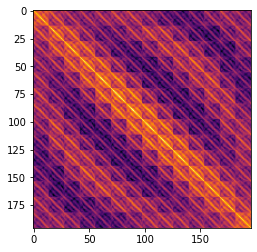

In [ ]:
position_embeddings = vit_base_i21k_patch16_224.layers[1].positional_embedding.numpy()

# Discard the batch dimension and the position embeddings of the
# cls token.
position_embeddings = position_embeddings.squeeze()[1:, ...]

similarity = position_embeddings @ position_embeddings.T
plt.imshow(similarity, cmap="inferno")
plt.show()

**포지셔널 임베딩은 무엇을 의미하는가?** 
- 그림은 뚜렷한 대각선 패턴을 가지며, 주 대각선(가운데)은 위치가 자신과 가장 유사하다는 것을 나타내는 가장 밝은 대각선 
- 주목해야 할 흥미로운 패턴은 반복되는 대각선이며, 반복 패턴은 [Vaswani et. al](https://arxiv.org/abs/1706.03762)이 수작업으로 제안한 것과 본질적으로 가까운 사인파 함수를 묘사한다. 

## Notes

* DINO extended the attention heatmap generation process to videos. We also
[applied](https://github.com/sayakpaul/probing-vits/blob/main/notebooks/dino-attention-map
s-video.ipynb) our DINO implementation on a series of videos and obtained similar
results. Here's one such video of attention heatmaps:

  ![dino](https://i.imgur.com/kAShjbs.gif)

* [Raghu et al.](https://arxiv.org/abs/2108.08810) use an array of techniques to
investigate the representations learned by ViTs and make comparisons with that of
ResNets. We strongly recommend reading their work.

* To author this example, we developed
[this repository](https://github.com/sayakpaul/probing-vits) to guide our readers so that they
can easily reproduce the experiments and extend them.

* Another repository that you may find interesting in this regard is
[`vit-explain`](https://github.com/jacobgil/vit-explain).

* One can also plot the attention rollout and attention heat maps with
custom images using our Hugging Face spaces.

| Attention Heat Maps | Attention Rollout |
| :--: | :--: |
| [![Generic badge](https://img.shields.io/badge/🤗%20Spaces-Attention%20Heat%20Maps-black.svg)](https://huggingface.co/spaces/probing-vits/attention-heat-maps) | [![Generic badge](https://img.shields.io/badge/🤗%20Spaces-Attention%20Rollout-black.svg)](https://huggingface.co/spaces/probing-vits/attention-rollout) |

## Acknowledgements

- [PyImageSearch](https://pyimagesearch.com)
- [Jarvislabs.ai](https://jarvislabs.ai/)
- [GDE Program](https://developers.google.com/programs/experts/)